# Assignment 1 - __M&M Factory QA__

- To calculate:

    - [ ] Color distribuition. Must warn if any color is missing
    
    - [ ] Average shape area in mm and organized by color
    
[Documentation online](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)
     
 A) Calibrate intrinsic paramenters and lens distortion of the camera. Show the intrinsic matrix and the lens distortion coeffiecients.
  

In [ ]:
%pip install opencv-python
%pip install matplotlib

Loading Image data/IntrinsicCalibration/calib_img_0.png


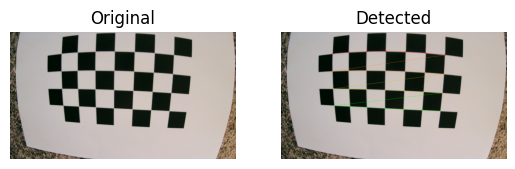

Loading Image data/IntrinsicCalibration/calib_img_1.png


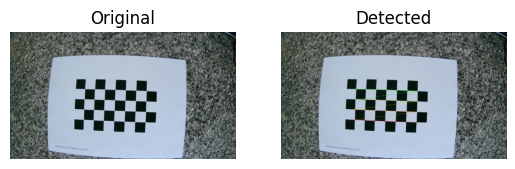

Loading Image data/IntrinsicCalibration/calib_img_2.png


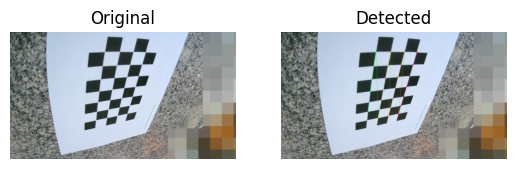

Loading Image data/IntrinsicCalibration/calib_img_3.png


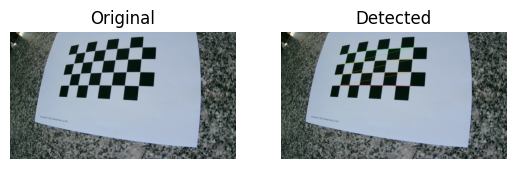

Loading Image data/IntrinsicCalibration/calib_img_4.png


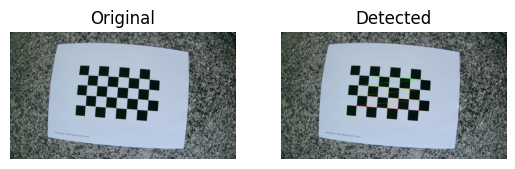

Loading Image data/IntrinsicCalibration/calib_img_5.png


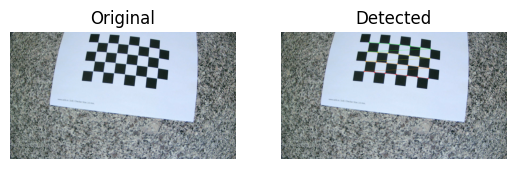

Loading Image data/IntrinsicCalibration/calib_img_6.png


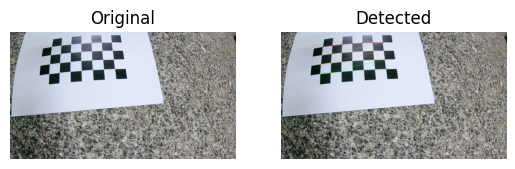

Loading Image data/IntrinsicCalibration/calib_img_7.png


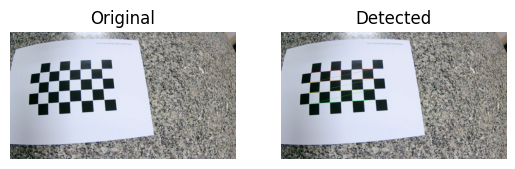

Loading Image data/IntrinsicCalibration/calib_img_8.png


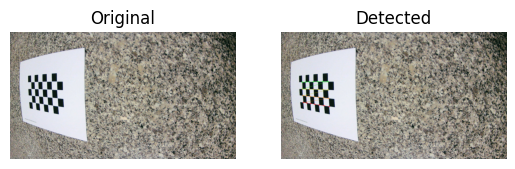

Loading Image data/IntrinsicCalibration/calib_img_9.png


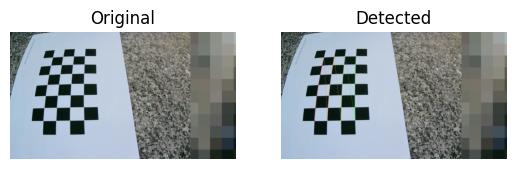

In [61]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob

grid_size = (7,4) # tuple that says the grid size (note these are interior corners)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_[0-9].png'))

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCornersSB(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, grid_size, corners2, ret)
        
    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Detected')
    plt.show()
    
    



In [54]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


<function print>

Loading Image data/IntrinsicCalibration/calib_img_0.png


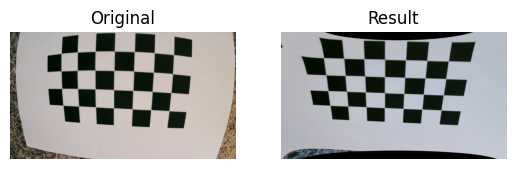

Loading Image data/IntrinsicCalibration/calib_img_1.png


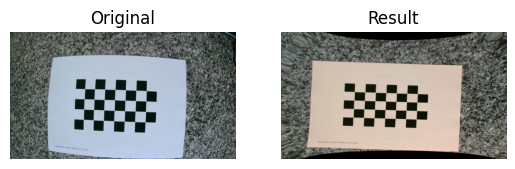

Loading Image data/IntrinsicCalibration/calib_img_2.png


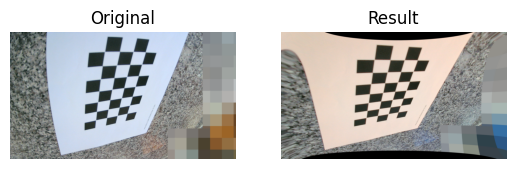

Loading Image data/IntrinsicCalibration/calib_img_3.png


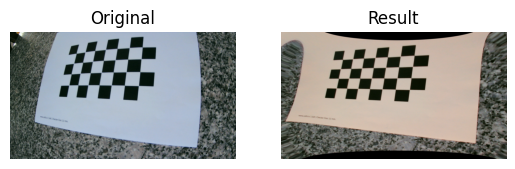

Loading Image data/IntrinsicCalibration/calib_img_4.png


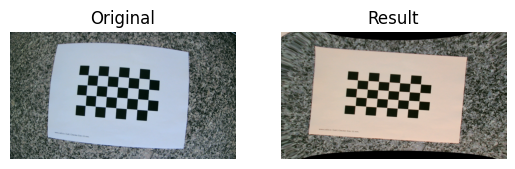

Loading Image data/IntrinsicCalibration/calib_img_5.png


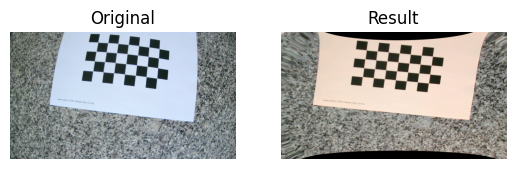

Loading Image data/IntrinsicCalibration/calib_img_6.png


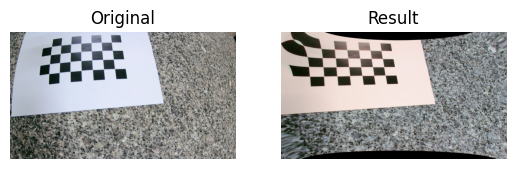

Loading Image data/IntrinsicCalibration/calib_img_7.png


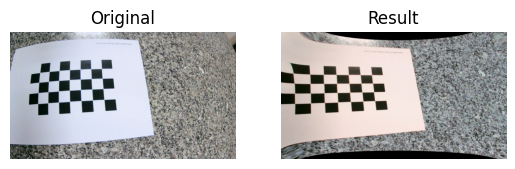

Loading Image data/IntrinsicCalibration/calib_img_8.png


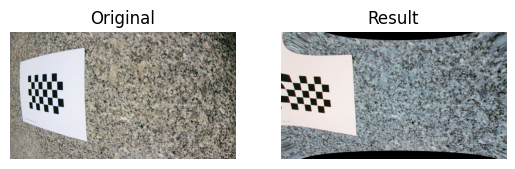

Loading Image data/IntrinsicCalibration/calib_img_9.png


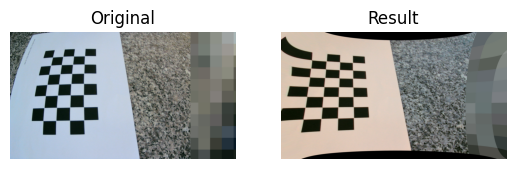

In [62]:
images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_[0-9].png'))

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    #x, y, w, h = roi
    #dst = dst[y:y+h, x:x+w]
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(dst)
    plt.title("Undistorted")
    plt.show()